# 🤔Summary
**Introduction:** Passenger in a spaceship traveling to some distant planet in the future. There was an incident that transported some of the passengers to a different reality.

**Problem:** What is the cause of the incident?

**Hypothesis:** If we can pinpoint shared traits among survivors and casualties, we'll clarify the incident's cause and solve the mystery.

**Goal:** To predict probability of survival of each passengers.

---
[kaggle](https://www.kaggle.com/code/fiftythirtyfour/spaceship-titanic)

## What I know so far...
- People in Cryo-Sleep were most likely transported.
- Rich people who used Roomservice, VRDeck and Spa were less likely to be transported.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.options.display.max_rows = 300
pd.options.display.max_columns = 300

## Load
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

## Cleaning
df['group_id'] = df['PassengerId'].transform(lambda x: x.split('_')[1]) ## Group ID found in the PassengerId

## Organize Columns
target = 'Transported' ### What we are trying to predict.
num = [x for x in df.columns if df.dtypes[x] in ['float64']]
cat = [x for x in df.columns if df.dtypes[x] == 'object']
cat.remove('PassengerId')

In [2]:
## Train Test Split by group
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0)
for tr_idx, te_idx in split.split(df, df['group_id']):
    train = df.loc[tr_idx]
    test = df.loc[te_idx]

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_id
5826,6168_02,Earth,False,G/999/S,55 Cancri e,12.0,False,0.0,0.0,0.0,0.0,0.0,Glenna Gordond,True,02
6832,7219_03,Europa,True,C/235/P,TRAPPIST-1e,64.0,False,0.0,0.0,0.0,0.0,0.0,Dirk Arible,True,03
8588,9168_01,Europa,False,C/338/S,55 Cancri e,36.0,False,23.0,14773.0,0.0,1159.0,7819.0,Hadirk Cassiding,False,01
1374,1450_01,Europa,True,D/53/S,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,0.0,Tabih Ailled,True,01
3242,3485_02,Europa,True,E/237/S,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Ankabih Tradve,True,02


# 🤓Data

## TODO
- Check the Passenger Id Group prefix

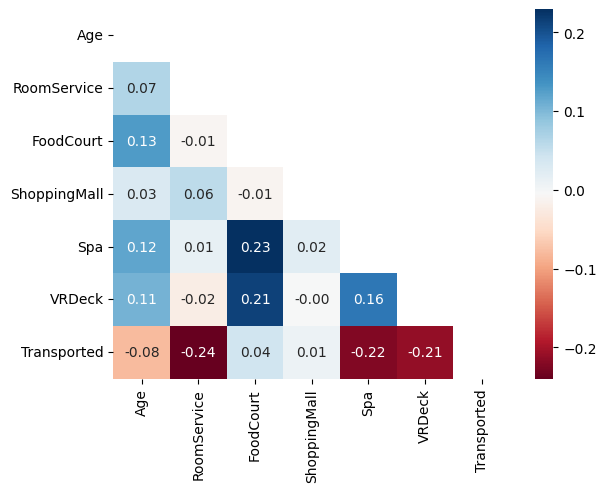

In [4]:
g = train[num + [target]].corr()
np.fill_diagonal(g.values, 0)
mask = np.triu(np.ones_like(g, dtype=bool))
sns.heatmap(g, annot=True, cmap='RdBu', mask=mask, fmt='.2f');

In [5]:
train.groupby('HomePlanet')[target].mean()

HomePlanet
Earth     0.424267
Europa    0.662398
Mars      0.531673
Name: Transported, dtype: float64

In [6]:
train.groupby('CryoSleep')[target].agg(['mean', 'sum', 'count'])

,mean,sum,count
CryoSleep,,,
False,0.331108,1438,4343
True,0.823457,2001,2430


In [7]:
train.isnull().mean()

PassengerId     0.000000
HomePlanet      0.021139
CryoSleep       0.026028
Cabin           0.023871
Destination     0.020564
Age             0.021858
VIP             0.023871
RoomService     0.020276
FoodCourt       0.020995
ShoppingMall    0.023727
Spa             0.021139
VRDeck          0.020851
Name            0.024159
Transported     0.000000
group_id        0.000000
dtype: float64

# 🤖Model
## Feature Engineering

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes]

In [10]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dframe = pd.DataFrame({
            'group_id': X['PassengerId'].transform(lambda x: x.split('_')[1])
        })
        return dframe

## Pipeline

In [11]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [12]:
num

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [13]:
cat_pp = Pipeline([
    ('dataselect', DataSelect(['CryoSleep', 'PassengerId']))
    , ('featureengineer', FeatureEngineer())
#     , ('impute', SimpleImputer(strategy='constant', fill_value='empty'))
    , ('encoder', OneHotEncoder(sparse_output=False))
])

num_pp = Pipeline([
    ('dataselect', DataSelect(num))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

pipe = FeatureUnion([
    ('cat', cat_pp)
    , ('num', num_pp)
])

pipe.fit(train)
train_pp = pipe.transform(train)
test_pp = pipe.transform(test)

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

In [15]:
gnb = GaussianNB()
gnb.fit(train_pp, train[target])
cross_val_score(gnb, train_pp, train[target]).mean()

0.6852181288757635

In [16]:
svc = SVC()
svc.fit(train_pp, train[target])
cross_val_score(svc, train_pp, train[target]).mean()

0.7868844421227935

In [17]:
dcs = DecisionTreeClassifier()
dcs.fit(train_pp, train[target])
cross_val_score(dcs, train_pp, train[target]).mean()

0.7211666985606339

In [18]:
rfc = RandomForestClassifier()
rfc.fit(train_pp, train[target])
cross_val_score(rfc, train_pp, train[target]).mean()

0.7785442903764694

In [19]:
model_base = svc

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
# params = {
#     "kernel": ["poly"]
#     , "degree": [1, 10]
#     , "coef0": [1, 50]
#     , "C": [5]
# }

# grd = GridSearchCV(model_base, param_grid=params)
# grd.fit(train_pp, train[target])
# grd.best_params_

In [22]:
model_tune = SVC(kernel='poly', degree=3, coef0=1, C=5)
model_tune.fit(train_pp, train[target]);

## Validation

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [24]:
def getPreds(m, x, y):
    return cross_val_predict(m, x, y)

def getScore(v, x, y, m):
    return v(y, getPreds(m, x, y))

In [25]:
valid = [accuracy_score, precision_score, recall_score, f1_score]
dfspl = [('train', train_pp, train[target]), ('test', test_pp, test[target])]
model = [model_base, model_tune]
for v in valid:
    print(v.__name__)
    for m in model:
        print(str(m))
        for n, x, y in dfspl:
            print(n, getScore(v, x, y, m))

accuracy_score
SVC()
train 0.7868852459016393
test 0.7688326624496837
SVC(C=5, coef0=1, kernel='poly')
train 0.7830025884383088
test 0.7648073605520413
precision_score
SVC()
train 0.7490864799025578
test 0.7136060894386299
SVC(C=5, coef0=1, kernel='poly')
train 0.7551846231664138
test 0.7188118811881188
recall_score
SVC()
train 0.8718457612702013
test 0.881316098707403
SVC(C=5, coef0=1, kernel='poly')
train 0.8466118514318117
test 0.8531139835487661
f1_score
SVC()
train 0.8058176100628931
test 0.7886435331230284
SVC(C=5, coef0=1, kernel='poly')
train 0.7982889987969524
test 0.7802256851155293


## Submission

In [26]:
samp = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
pd.DataFrame({
    "PassengerId": samp["PassengerId"]
    , "Transported": model_tune.predict(pipe.transform(samp))
}).to_csv('submission.csv', index=False)

# 📌Notes to Self
I still cannot see how I can keep improving my score without visualizing the model performance. Try to get a confusion matrix working.